# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://tip.duke.edu/independent_learning/greek/lesson/digging_deeper_final.jpg)



In [ ]:
# In Google Colab, uncomment this:
# !wget https://bit.ly/2FMJP5K -O setup.py && bash setup.py

# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

state vector dim = 4
n_actions = 2


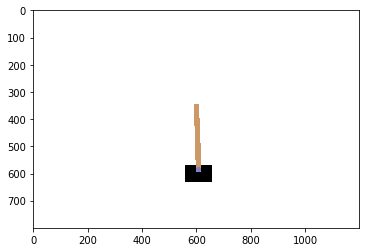

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

In [123]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
    warm_start=True,
    max_iter=2
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 20), learning_rate='constant',
              learning_rate_init=0.001, max_iter=2, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=True)

In [141]:
agent.predict_proba([[ 0.04076579,  0.15259605,  0.01352642, -0.33232651]]).reshape(-1)

array([0.33189276, 0.66810724])

# Neural Network Policy

In [47]:
import torch
from torch import nn

In [179]:
input_size = 4
hidden_sizes = [20, 100, 20]
output_size = 2

torch_agent = nn.Sequential(
                    nn.Linear(input_size, hidden_sizes[0]),
                    nn.ReLU(),
                    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                    nn.ReLU(),
                    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                    nn.Tanh(),
                    nn.Linear(hidden_sizes[2], output_size),
                    nn.Softmax(dim=1)
)

In [173]:
print(torch_agent.parameters)

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=4, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=2, bias=True)
  (7): Softmax(dim=1)
)>


In [174]:
def generate_session(agent, predict, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
#         probs = agent(torch.from_numpy(np.array([s])).float())
#         probs = probs.detach().numpy()[0]
        probs = predict(agent, s)

        assert probs.shape == (n_actions,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(2, p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [175]:
def torch_predict(agent, s):
    probs = agent(torch.from_numpy(np.array([s])).float())
    probs = probs.detach().numpy().reshape(-1)
    return probs

def mlp_predict(agent, s):
    probs = agent.predict_proba([s]).reshape(-1)
    return probs

In [176]:
dummy_states, dummy_actions, dummy_reward = generate_session(torch_agent, torch_predict, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-0.02531717 -0.02582489  0.00444392 -0.02054276]
 [-0.02583367  0.16923305  0.00403307 -0.31182027]
 [-0.02244901  0.36429731 -0.00220334 -0.60322857]
 [-0.01516306  0.55945001 -0.01426791 -0.89660469]
 [-0.00397406  0.75476246 -0.0322     -1.19373816]]
actions: [1, 1, 1, 1, 1]
reward: 5.0


In [147]:
dummy_states, dummy_actions, dummy_reward = generate_session(agent, mlp_predict, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[ 0.04433035  0.03052258 -0.03603899  0.02547136]
 [ 0.04494081  0.22614233 -0.03552956 -0.2783609 ]
 [ 0.04946365  0.42175265 -0.04109678 -0.5820347 ]
 [ 0.05789871  0.61742558 -0.05273748 -0.88737533]
 [ 0.07024722  0.81322216 -0.07048498 -1.1961595 ]]
actions: [1, 1, 1, 1, 0]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [102]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = \
        np.array([np.array(states_batch[i]) for i in range(len(rewards_batch)) if rewards_batch[i] >= reward_threshold])
    elite_actions = \
        np.array([np.array(actions_batch[i]) for i in range(len(rewards_batch)) if rewards_batch[i] >= reward_threshold])
    
    elite_states = np.concatenate(elite_states)
    elite_actions = np.concatenate(elite_actions)

    return elite_states, elite_actions

# Training loop
Generate sessions, select N best and fit to those.

In [120]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [180]:
n_sessions = 100
percentile = 30
log = []

loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-2
optimizer = torch.optim.LBFGS(torch_agent.parameters(), max_iter=2, lr=learning_rate)
optimizer.zero_grad()

def closure():
    y_pred = torch_agent(X.float())
    loss = loss_fn(y_pred, y)
    loss.backward()
    print('{} {} {}'.format(y_pred.detach().numpy(), y.detach().numpy(), loss.detach()))
    return loss
    
for i in range(100):
    # generate new sessions
    sessions = list([generate_session(torch_agent, torch_predict, t_max=1000) for _ in range(n_sessions)])

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, \
                                                actions_batch, rewards_batch, percentile)

    X = torch.from_numpy(elite_states)
    y = torch.from_numpy(elite_actions)

    optimizer.step(closure)
    

#     show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! Will be stopped")
        break

[[0.5908796  0.4091204 ]
 [0.5930116  0.40698844]
 [0.59103525 0.4089647 ]
 ...
 [0.59420574 0.40579426]
 [0.5955537  0.40444627]
 [0.596608   0.40339196]] [1 0 0 ... 0 0 0] 0.6843788027763367
[[0.59097356 0.4090264 ]
 [0.59310603 0.40689403]
 [0.5911292  0.40887076]
 ...
 [0.5943012  0.40569884]
 [0.5956501  0.40434995]
 [0.596705   0.40329495]] [1 0 0 ... 0 0 0] 0.6843740344047546
[[0.5907701  0.40922987]
 [0.5902556  0.40974435]
 [0.59015316 0.40984687]
 ...
 [0.5910762  0.40892383]
 [0.59161514 0.40838492]
 [0.59312147 0.40687856]] [0 0 0 ... 0 0 1] 0.6840682625770569
[[0.5910603  0.40893975]
 [0.59054387 0.4094561 ]
 [0.5904406  0.4095594 ]
 ...
 [0.591366   0.408634  ]
 [0.59190536 0.40809467]
 [0.59341145 0.40658855]] [0 0 0 ... 0 0 1] 0.6840524673461914
[[0.59185183 0.40814826]
 [0.59358966 0.40641037]
 [0.5916603  0.40833968]
 ...
 [0.59389293 0.406107  ]
 [0.59550494 0.40449503]
 [0.59686255 0.40313742]] [1 0 1 ... 0 0 0] 0.6824867129325867
[[0.59238464 0.40761533]
 [0.594128

KeyboardInterrupt: 

mean reward = 198.570, threshold=161.400


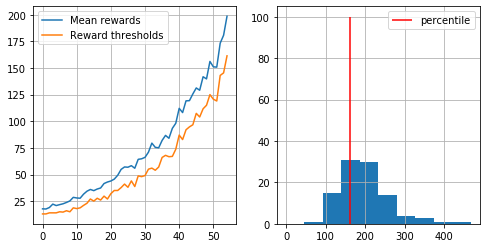

You Win! Will be stopped


In [151]:
n_sessions = 100
percentile = 30
log = []

for i in range(100):
    # generate new sessions
    sessions = list([generate_session(agent, mlp_predict, t_max=1000) for _ in range(n_sessions)])

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, \
                                                actions_batch, rewards_batch, percentile)
        
    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! Will be stopped")
        break

# Results

In [160]:
!rm videos/*

In [156]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session(agent, mlp_predict) for _ in range(100)]
env.close()

In [157]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`.
- __1.2__ (2 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


```<Describe what you did here.  Preferably with plot/report to support it.>```

# Homework part II

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (bonus: 4++ pt) Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  * __Please list what you did in anytask submission form__
  
  
### Tips
* Gym page: [MountainCar](https://gym.openai.com/envs/MountainCar-v0), [LunarLander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

In [ ]:
def visualize_mountain_car(env, agent):
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    grid = np.dstack(np.meshgrid(xs, vs)).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3)
    return probs

plt.imshow(visualize_mountain_car(env, agent))

### Bonus tasks

* __2.3 bonus__ Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in anytask submission._)

* __2.4 bonus__ Solve continuous action space task with `MLPRegressor` or similar.
  * Start with ["Pendulum-v0"](https://github.com/openai/gym/wiki/Pendulum-v0).
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) 
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules aside from action spaces.


If you're still feeling unchallenged, consider the project (see other notebook in this folder).